# Using `memento` to analyze Interferon-B response in monocytes

To install `memento` in the pre-release version (for Ye Lab members), install it directly from github by running:

```pip install git+https://github.com/yelabucsf/scrna-parameter-estimation.git@release-v0.0.9```

This requires that you have access to the Ye Lab organization. 

In [1]:
# This is only for development purposes

import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
import memento
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import scanpy as sc
import memento

In [3]:
fig_path = '~/Github/scrna-parameter-estimation/figures/fig4/'
data_path = '/data_volume/memento/demux/'

### Read IFN data and filter for monocytes

For `memento`, we need the raw count matrix. Preferrably, feed the one with all genes so that we can choose what genes to look at. `adata.X` should be a sparse matrix containing positive integers.

One of the columns in `adata.obs` should be the discrete groups to compare mean, variability, and co-variability across. In this case, it's called `stim`. 

The column containing the covariate that you want p-values for should either:
- Be binary (aka the column only contains two unique values, such as 'A' and 'B'. Here, the values are either 'stim' or 'ctrl'.
- Be numeric (aka the column contains -1, 0, -1 for each genotype value). 

I recommend changing the labels to something numeric (here, i use 0 for `ctrl` and 1 for `stim`). Otherwise, the sign of the DE/EV/DC testing will be very hard to interpret.

In [5]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
print(adata)

AnnData object with n_obs × n_vars = 5341 × 35635
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'cell_type'
    var: 'gene_ids', 'mt', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors'
    obsm: 'X_tsne'


In [6]:
adata.obs['stim'] = adata.obs['stim'].apply(lambda x: 0 if x == 'ctrl' else 1)

In [7]:
adata.obs[['ind', 'stim', 'cell']].sample(5)

,ind,stim,cell
index,,,
TCGCACACGGCGAA-1,1015,1,CD14+ Monocytes
TCTACAACCGATAC-1,1015,0,CD14+ Monocytes
AATGTTGATTGTGG-1,1015,0,CD14+ Monocytes
TAGGCAACGCTTAG-1,1015,0,CD14+ Monocytes
TACTACACAAGGCG-1,1015,0,CD14+ Monocytes


### Spef

`memento` creates groups of cells based on anything that should be considered a reasonable group; here, we just divide the cells into `stim` and `ctrl`. But we can easily further divide the cells into individuals by adding the `ind` column to the `label_columns` argument when calling `create_groups`.

Values in the `q_column` is the rough estimate of the overall UMI efficiency across both sampling and sequencing. If `s` is the sequencing saturation, multiply `s` by 0.07 for 10X v1, 0.15 for v2, and 0.25 for v3. This allows you to enter different numbers for each batch, which likely have different saturation numbers. This will NOT account for wildly different sequencing scenarios.

By default, `memento` will consider all genes whose expression is high enough to calculate an accurate variance.

In [8]:
from scipy.sparse.csr import csr_matrix

In [9]:
type(adata.X) == csr_matrix

True

In [10]:
adata.obs['capture_rate'] = 0.07
memento.setup_memento(adata, q_column='capture_rate')

In [11]:
memento.create_groups(adata, label_columns=['stim'])

In [12]:
memento.compute_1d_moments(adata,
    min_perc_group=.9) # percentage of groups that satisfy the condition for a gene to be considered. 

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Perform 1D hypothesis testing

`formula_like` determines the linear model that is used for hypothesis testing, while `cov_column` is used to pick out the variable that you actually want p-values for. 

`num_cpus` controls how many CPUs to parallelize this operation for. In general, I recommend using 3-6 CPUs for reasonable peformance on any of the AWS machines that we have access to (I'm currently using a c5.2xlarge instance (8 vCPUs). 

In [13]:
sample_meta = memento.get_groups(adata)

In [14]:
sample_meta

,stim
sg^0,0
sg^1,1


In [15]:
# we dont have covariates so just column of 1s
cov_df = pd.DataFrame(index=sample_meta.index)
cov_df['intercept'] = 1

In [16]:
memento.ht_1d_moments(
    adata, 
    treatment=sample_meta,
    covariate=cov_df,
    resampling='bootstrap',
    num_boot=5000, 
    verbose=1,
    num_cpus=12)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    7.5s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   13.8s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   22.8s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:   35.1s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:   50.0s
[Parallel(n_jobs=12)]: Done 1877 out of 1877 | elapsed:   53.2s finished


In [17]:

result_1d = memento.get_1d_ht_result(adata)

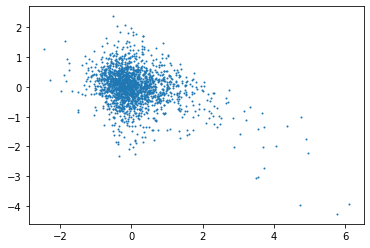

In [18]:
plt.scatter(result_1d.de_coef, result_1d.dv_coef, s=1)

In [19]:
result_1d.query('de_coef > 0').sort_values('de_pval').head(10)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
800,NUB1,stim,1.553159,0.074716,6.215217e-11,0.217814,0.350639,5.390922e-01
1821,RTCB,stim,2.305291,0.074885,3.913019e-10,-0.208805,0.231325,3.569286e-01
1376,B2M,stim,0.429512,0.010407,4.699689e-10,-0.291800,0.043544,9.513078e-05
811,SAT1,stim,1.287164,0.023795,4.640998e-09,0.565544,0.153293,1.862089e-03
1039,IFITM3,stim,3.502473,0.049921,6.790213e-09,-3.046652,0.105992,4.349423e-07
1789,ATF5,stim,1.294835,0.046064,1.178332e-08,-0.349422,0.225480,1.203759e-01
1831,APOBEC3A,stim,3.695553,0.053684,1.867388e-08,-2.008880,0.153805,1.376400e-06
296,TNFAIP6,stim,1.740791,0.117455,2.041200e-08,-1.445899,0.758585,9.638072e-02
1300,PSME2,stim,0.929220,0.024745,2.074298e-08,-0.876211,0.079066,1.386437e-05
1411,PSMA4,stim,1.286966,0.031059,2.471412e-08,0.082210,0.173142,6.288742e-01


In [20]:
result_1d.query('dv_coef > 0 & de_coef > 0').sort_values('dv_pval').head(10)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
171,FCER1G,stim,0.164132,0.015344,4.423458e-04,0.346998,0.068243,0.000144
1828,LGALS1,stim,0.018909,0.018201,3.081384e-01,0.476514,0.063816,0.000166
114,RHOC,stim,0.346172,0.075301,2.336530e-04,1.348273,0.314085,0.000309
1537,CCR7,stim,1.031435,0.136378,1.388279e-04,1.025511,0.239285,0.000469
1827,LGALS2,stim,1.372170,0.078221,2.093057e-07,0.760032,0.164551,0.000556
1309,FAM177A1,stim,0.892508,0.046283,1.734628e-06,1.484845,0.290822,0.001069
137,S100A11,stim,0.216704,0.013112,2.274362e-04,0.262594,0.072342,0.001208
1392,RPS27L,stim,0.401444,0.046963,2.216826e-05,0.623484,0.164494,0.001412
811,SAT1,stim,1.287164,0.023795,4.640998e-09,0.565544,0.153293,0.001862
1258,SAP18,stim,0.794756,0.029937,3.226556e-06,0.856346,0.226751,0.002027


### Perform 2D hypothesis testing

For differential coexpression testing, we can specify which genes you want to perform HT on. It takes a list of pairs of genes, where each element in the list is a tuple. Here, we focus on 1 transcription factor and their correlations to rest of the transcriptome. 

Similar to the 1D case, 2D hypothesis testing scales with the number of pairs of genes to test. If you have a smaller set of candidate genes, it will run faster.

In [21]:
import itertools

In [22]:
gene_pairs = list(itertools.product(['IRF7'], adata.var.index.tolist()))

In [23]:
memento.compute_2d_moments(adata, gene_pairs)

In [24]:
memento.ht_2d_moments(
    adata, 
    treatment=sample_meta,
    covariate=cov_df,
    resampling='bootstrap',
    num_boot=5000, 
    verbose=1,
    num_cpus=12)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   10.7s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   24.4s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   44.9s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 1876 out of 1876 | elapsed:  1.8min finished


In [25]:
result_2d = memento.get_2d_ht_result(adata)

In [26]:
result_2d.sort_values('corr_pval').head(10)

,gene_1,gene_2,corr_coef,corr_se,corr_pval
1148,IRF7,HSPA8,0.324572,0.055779,0.000071
1815,IRF7,SDF2L1,0.339628,0.057296,0.000072
716,IRF7,ACTB,0.301092,0.051565,0.000073
626,IRF7,HLA-C,0.288379,0.056345,0.000127
638,IRF7,HLA-DRA,0.270858,0.045645,0.000130
1186,IRF7,TMBIM6,0.323705,0.070810,0.000156
1406,IRF7,PKM,0.331415,0.066212,0.000159
493,IRF7,ANXA5,0.277261,0.050891,0.000199
158,IRF7,LMNA,0.317306,0.065649,0.000204
241,IRF7,RTN4,0.427435,0.084289,0.000227


### Save your results

There are some objects within `memento` that doesn't play nice with scanpy. So just give it a heads up with the `prepare_to_save` function.

In [27]:
memento.prepare_to_save(adata)

In [28]:
adata.write(data_path + 'ifn_tutorial.h5ad')

... storing 'memento_group' as categorical
